# PROJECT PREREQUISITES
* Make sure you install all the necessary libraries below before runnning this notebook.
* Make sure you configure the .env file by inputting the api keys for Gemini and LangSmith.

In [24]:
import operator
import os
import pandas as pd
from datetime import datetime
from typing import Annotated, Sequence, TypedDict, List, Union, Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import create_react_agent 
import yfinance as yf
from newspaper import Article
from datetime import datetime
from dotenv import load_dotenv
from IPython.display import Image, display

In [2]:
# --- CONFIGURATION ---
load_dotenv("./.env")  # Load .env file

#setup LangSmith for tracing and debugging
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Financial_Council_Agent"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")

# Gemini 2.0 Flash
llm_flash = ChatGoogleGenerativeAI(model="gemini-2.0-flash", api_key=os.getenv("GEMINI_API_KEY"), temperature=0)

In [3]:
llm_flash.invoke("Who are you?")

AIMessage(content='I am a large language model, trained by Google.', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019b1bb5-c49e-7a50-9d6b-504f338bb32f-0', usage_metadata={'input_tokens': 4, 'output_tokens': 12, 'total_tokens': 16, 'input_token_details': {'cache_read': 0}})

In [4]:
#FOR TESTING GET STOCK FUNDAMENTALS TOOL
def func_get_stock_fundamentals(ticker: str):
    """
    Retrieves key financial metrics including 3-Year historical growth, 
    Next 2-Year forecasted growth, Margins, FCF, and Valuation Ratios.
    """
    try:
        stock = yf.Ticker(ticker)
        
        # 1. Fetch Key Dataframes
        info = stock.info
        financials = stock.financials # Income Statement
        cashflow = stock.cashflow     # Cash Flow Statement
        estimates = stock.revenue_estimate #Revenue Estimation by Analyst
        q_financials = stock.quarterly_financials #Quarterly Financial Data
        q_cashflow = stock.quarterly_cashflow     # Cash Flow Statement

        # --- PREPARATION: Get Basic Variables ---
        market_cap = stock.fast_info['market_cap']
        
        if market_cap is None:
            # Fallback if fast_info fails (rare)
            market_cap = info.get('marketCap')
        
        # Extract the last 4 quarters (columns 0 to 4) to get the TTM Data
        # yfinance columns are usually sorted by date descending (newest first)
        last_4_quarters_financials = q_financials.iloc[:, :4]
        last_4_quarters_cash_flow = q_cashflow.iloc[:, :4]
        #Sum them to get TTM values
        ttm_op_income = last_4_quarters_financials.loc['Operating Income'].sum()
        ttm_revenue = last_4_quarters_financials.loc['Total Revenue'].sum()
        ttm_fcf =last_4_quarters_cash_flow.loc['Free Cash Flow'].sum()
        
        # Get Revenue (Current vs 3-Year Ago)
        try:
            rev_current = financials.loc['Total Revenue'].iloc[0]
            rev_3yr_ago = financials.loc['Total Revenue'].iloc[3]
        except (IndexError, KeyError):
            rev_current = None
            rev_3yr_ago = None

        # Get Free Cash Flow (Current vs 3-Year Ago)
        try:
            # Year 0 (Current)
            ocf_curr = cashflow.loc['Operating Cash Flow'].iloc[0]
            capex_curr = cashflow.loc['Capital Expenditure'].iloc[0]
            fcf_current = ocf_curr + capex_curr

            # Year 3 (3 Years Ago)
            ocf_3yr = cashflow.loc['Operating Cash Flow'].iloc[3]
            capex_3yr = cashflow.loc['Capital Expenditure'].iloc[3]
            fcf_3yr_ago = ocf_3yr + capex_3yr
        except (IndexError, KeyError):
            fcf_current = None
            fcf_3yr_ago = None

        # --- METRIC 1: Past 3-Year Revenue Growth (CAGR) ---
        if rev_current and rev_3yr_ago and rev_3yr_ago > 0:
            growth_3y = ((rev_current / rev_3yr_ago) ** (1/3)) - 1
        else:
            growth_3y = None

        # --- METRIC 2: Next 2 Years Forecasted Revenue Growth ---
        # Formula: ((Avg Est Next Year / Year Ago Sales Current Year) ^ 0.5) - 1
        forecast_growth = None
        if estimates is None or estimates.empty:
            return "N/A"
        try:
            # 1. Get the Numerator: Average Estimated Revenue for Next Year (+1y)
            # We look for the '+1y' row and the 'avg' column
            next_year_est = estimates.loc['+1y', 'avg']
            
            # 2. Get the Denominator: Year-ago Revenue for Current Year (0y)
            # We look for the '0y' row and the 'yearAgoRevenue' column
            # This represents the actual confirmed revenue from the last completed fiscal year.
            last_year_actual = estimates.loc['0y', 'yearAgoRevenue']
    
            # 3. Apply the Formula: ((Next Year Est / Last Year Actual) ^ 0.5) - 1
            forecast_growth = ((next_year_est / last_year_actual) ** 0.5) - 1
    
        except Exception as e:
            print(e)
            
        # --- METRIC 3: Operating Margin ---
        try:
            #Calculate Margin
            op_margin = ttm_op_income / ttm_revenue
        
        except KeyError as e:
            print(f"N/A (Key not found: {e})")
        except IndexError:
            print("N/A (Not enough quarterly data available)")
        except Exception as e:
            print(f"N/A (Error: {e})")

        # --- METRIC 4: FCF Growth / Change ---
        fcf_metric_name = "FCF Growth (3y)"
        fcf_metric_value = None

        if fcf_current is not None and fcf_3yr_ago is not None:
            if fcf_current > 0 and fcf_3yr_ago > 0:
                # CAGR Formula
                fcf_metric_value = ((fcf_current / fcf_3yr_ago) ** (1/3)) - 1
            else:
                # Absolute Change Formula (handles negative FCF)
                fcf_metric_name = "FCF Change (3y)"
                fcf_metric_value = (fcf_current - fcf_3yr_ago) / abs(fcf_3yr_ago)

        # --- METRIC 5: Valuation Ratios ---
        ps_ratio = market_cap / ttm_revenue if (market_cap and ttm_revenue) else None
        pfcf_ratio = market_cap / ttm_fcf if (market_cap and fcf_current) else None

        # --- FORMAT OUTPUT ---
        def fmt_pct(val): return f"{val:.2%}" if val is not None else "N/A"
        def fmt_num(val): return f"${val:,.0f}" if val is not None else "N/A"
        def fmt_rat(val): return f"{val:.2f}" if val is not None else "N/A"
    
        return {
            "Ticker": ticker.upper(),
            "Current Market Cap": fmt_num(market_cap), 
            "3-Year Revenue Growth": fmt_pct(growth_3y),
            "Next 2-Year Forecast Growth": fmt_pct(forecast_growth) if forecast_growth else "N/A (No Analyst Data)",
            "Operating Margin": fmt_pct(op_margin),
            f"{fcf_metric_name}": fmt_pct(fcf_metric_value),
            "Latest FCF": fmt_num(fcf_current),
            "Price to Sales (P/S)": fmt_rat(ps_ratio),
            "Price to FCF (P/FCF)": fmt_rat(pfcf_ratio)
        }

    except Exception as e:
        return f"Failed to analyze {ticker}: {str(e)}"

In [5]:
func_get_stock_fundamentals('NVDA')

{'Ticker': 'NVDA',
 'Current Market Cap': '$4,261,212,044,022',
 '3-Year Revenue Growth': '69.25%',
 'Next 2-Year Forecast Growth': '55.48%',
 'Operating Margin': '58.84%',
 'FCF Growth (3y)': '95.60%',
 'Latest FCF': '$60,853,000,000',
 'Price to Sales (P/S)': '22.77',
 'Price to FCF (P/FCF)': '55.11'}

In [33]:
#FOR TESTING GET STOCK NEWS TOOL
def get_stock_news(ticker_symbol):
    """
    Fetches top 5 news items for a stock ticker, scrapes news content, AND summarizes it using llm_flash.
    """
    try:
        # 1. Get Links
        # Using a try-except block specifically for yf.Search to be safe
        try:
            search = yf.Search(ticker_symbol, news_count=5)
            news_list = search.news
        except Exception:
            news_list = []
        
        # Fallback to Ticker if Search returns nothing (redundancy)
        if not news_list:
            try:
                t = yf.Ticker(ticker_symbol)
                news_list = t.news
            except Exception:
                pass

        if not news_list:
            return "No news found."
            
        formatted_news = []
        print(f"Found {len(news_list)} links. Scraping & Summarizing with Gemini Flash...")

        for item in news_list:
            link = item.get('link')
            
            # 2. Extract Content
            article_content = ""
            try:
                if link:
                    article = Article(link)
                    article.download()
                    article.parse()
                    article_content = article.text
            except Exception:
                # If scraping fails, just skip this article or mark as failed
                continue 
            
            # 3. Summarize Content
            if article_content:
                # Call our helper function that uses llm_flash
                summary = summarize_text(article_content, ticker_symbol)
            else:
                summary = "N/A (Could not extract text)"

            # 4. Format Output
            pub_time = item.get('providerPublishTime')
            date_str = datetime.fromtimestamp(pub_time).strftime('%Y-%m-%d') if pub_time else "N/A"

            formatted_news.append({
                "title": item.get('title', 'No Title'),
                "date": date_str,
                "publisher": item.get('publisher', 'Unknown'),
                "link": link,
                "summary": summary 
            })
            
        return formatted_news

    except Exception as e:
        return f"Error in news tool: {e}"
    
# Test with Google (GOOGL)
news = get_stock_news("GOOGL")

print(f"Found {len(news)} articles:")

for n in news[:5]:
    print(f"- {n['date']} | {n['publisher']}: {n['title']} - {n['link']}")
    print(f"  Link: {n['summary']}\n")

Found 5 links. Scraping & Summarizing with Gemini Flash...
Found 5 articles:
- 2025-12-14 | Motley Fool: Prediction: This AI Stock Could Lead the Market in 2026 - https://finance.yahoo.com/m/d20eb998-9faf-30fa-bc6f-978c458b53f7/prediction%3A-this-ai-stock.html
  Link: *   **Positive Sentiment Driving Stock Surge:** Alphabet's stock (GOOGL) has surged over 80% since July 1, 2025, fueled by positive news and strong performance, indicating continued upward momentum into 2026.
*   **AI Leadership Threatens Competitors:** Alphabet's generative AI advancements, particularly the Gemini model, are reportedly challenging OpenAI's dominance, potentially leading to increased market share and revenue growth.
*   **Cloud Computing Growth and Profitability:** Google Cloud's revenue grew 34% year-over-year in Q3, with increasing profitability (operating margin up from 17% to 24%), driven by AI and traditional workloads, positioning it as a significant growth driver.

- 2025-12-14 | Motley Fool: Move 

In [72]:
#FOR TESTING GET TECHNICAL INDICATORS TOOL
def get_technical_indicators(ticker: str) -> dict:
    """
    Calculates key technical indicators (RSI, MACD, SMA) for a given stock.
    Useful for determining price trends and potential entry/exit points.
    """
    try:
        t = yf.Ticker(ticker)
        # Fetch 6 months of data to ensure enough history for 200-day or 50-day calc
        # Note: We need at least 26+9=35 days for MACD, so 6mo is safe.
        hist = t.history(period="6mo")
        
        if hist.empty:
            return {"error": "No historical price data found."}

        # --- A. Simple Moving Averages (SMA) ---
        # SMA 50: Short-term trend
        hist['SMA_50'] = hist['Close'].rolling(window=50).mean()
        
        # --- B. Relative Strength Index (RSI) ---
        # Formula: 100 - (100 / (1 + RS))
        delta = hist['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        
        rs = gain / loss
        hist['RSI'] = 100 - (100 / (1 + rs))

        # --- C. MACD (Moving Average Convergence Divergence) ---
        # EMA 12 - EMA 26
        ema_12 = hist['Close'].ewm(span=12, adjust=False).mean()
        ema_26 = hist['Close'].ewm(span=26, adjust=False).mean()
        hist['MACD'] = ema_12 - ema_26
        # Signal Line: 9-day EMA of MACD
        hist['MACD_Signal'] = hist['MACD'].ewm(span=9, adjust=False).mean()

        # --- Get Latest Values ---
        latest = hist.iloc[-1]
        
        # Determine Trend (Simple Logic for Agent)
        price = latest['Close']
        sma_50 = latest['SMA_50']
        trend = "Uptrend" if price > sma_50 else "Downtrend"
        
        # Determine RSI Status
        rsi = latest['RSI']
        rsi_status = "Neutral"
        if rsi > 70: rsi_status = "Overbought (High Risk of Pullback)"
        elif rsi < 30: rsi_status = "Oversold (Potential Bounce)"

        return {
            "current_price": f"${price:.2f}",
            "sma_50": f"${sma_50:.2f}" if pd.notnull(sma_50) else "N/A",
            "trend_50_day": trend,
            "rsi_14": f"{rsi:.1f}",
            "rsi_status": rsi_status,
            "macd_line": f"{latest['MACD']:.2f}",
            "macd_signal": f"{latest['MACD_Signal']:.2f}",
            "macd_interpretation": "Bullish Cross" if latest['MACD'] > latest['MACD_Signal'] else "Bearish"
        }

    except Exception as e:
        return {"error": f"Technical analysis failed: {str(e)}"}
    
print(get_technical_indicators('NVDA'))

{'current_price': '$175.02', 'sma_50': '$186.84', 'trend_50_day': 'Downtrend', 'rsi_14': '45.0', 'rsi_status': 'Neutral', 'macd_line': '-1.94', 'macd_signal': '-1.78', 'macd_interpretation': 'Bearish'}


In [74]:
# --- DEFINE STATE ---
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next_step: str

#Define the valid routing choices
class Route(BaseModel):
    step: Literal["StockAnalyst", "Accountant", "FINISH"] = Field(
        description="The next agent to act."
    )
    
# Single, reusable schema for ALL stock tools
class TickerInput(BaseModel):
    ticker: str = Field(..., description="The stock ticker symbol (e.g., 'NVDA', 'AAPL') to analyze.")

In [76]:
### HELPER FUNCTIONS DECLARATIONS
def summarize_text(text, ticker):
    """
    Helper to summarize raw news article text using  llm_flash instance.
    """
    if not text or len(text) < 200:
        return text  # text is too short to summarize

    try:
        # Define the prompt instructions
        system_prompt = (
            "You are a financial news summarizer. Summarize the following article in 3 bullet points. "
            "Focus specifically on how it impacts the stock price or future outlook. Be concise."
        )
        user_content = f"Ticker: {ticker}\nArticle Text: {text[:4000]}" # Truncate to save tokens

        # Create the message payload for LangChain
        messages = [
            SystemMessage(content=system_prompt),
            HumanMessage(content=user_content)
        ]

        # Invoke Gemini Flash
        response = llm_flash.invoke(messages)
        
        # Return the actual text content from the AIMessage
        return response.content

    except Exception as e:
        return f"Summarization failed: {e}. Raw snippet: {text[:200]}..."

In [75]:
### TOOLS DECLARATIONS
@tool(args_schema=TickerInput)
def get_stock_fundamentals(ticker: str):
    """
    Retrieves key financial metrics including 3-Year historical growth, 
    Next 2-Year forecasted growth, Margins, FCF, and Valuation Ratios.
    """
    try:
        stock = yf.Ticker(ticker)
        
        # 1. Fetch Key Dataframes
        info = stock.info
        financials = stock.financials # Income Statement
        cashflow = stock.cashflow     # Cash Flow Statement
        estimates = stock.revenue_estimate #Revenue Estimation by Analyst
        q_financials = stock.quarterly_financials #Quarterly Financial Data
        q_cashflow = stock.quarterly_cashflow     # Cash Flow Statement

        # --- PREPARATION: Get Basic Variables ---
        market_cap = stock.fast_info['market_cap']
        
        if market_cap is None:
            # Fallback if fast_info fails (rare)
            market_cap = info.get('marketCap')
        
        # Extract the last 4 quarters (columns 0 to 4) to get the TTM Data
        # yfinance columns are usually sorted by date descending (newest first)
        last_4_quarters_financials = q_financials.iloc[:, :4]
        last_4_quarters_cash_flow = q_cashflow.iloc[:, :4]
        #Sum them to get TTM values
        ttm_op_income = last_4_quarters_financials.loc['Operating Income'].sum()
        ttm_revenue = last_4_quarters_financials.loc['Total Revenue'].sum()
        ttm_fcf =last_4_quarters_cash_flow.loc['Free Cash Flow'].sum()
        
        # Get Revenue (Current vs 3-Year Ago)
        try:
            rev_current = financials.loc['Total Revenue'].iloc[0]
            rev_3yr_ago = financials.loc['Total Revenue'].iloc[3]
        except (IndexError, KeyError):
            rev_current = None
            rev_3yr_ago = None

        # Get Free Cash Flow (Current vs 3-Year Ago)
        try:
            # Year 0 (Current)
            ocf_curr = cashflow.loc['Operating Cash Flow'].iloc[0]
            capex_curr = cashflow.loc['Capital Expenditure'].iloc[0]
            fcf_current = ocf_curr + capex_curr

            # Year 3 (3 Years Ago)
            ocf_3yr = cashflow.loc['Operating Cash Flow'].iloc[3]
            capex_3yr = cashflow.loc['Capital Expenditure'].iloc[3]
            fcf_3yr_ago = ocf_3yr + capex_3yr
        except (IndexError, KeyError):
            fcf_current = None
            fcf_3yr_ago = None

        # --- METRIC 1: Past 3-Year Revenue Growth (CAGR) ---
        if rev_current and rev_3yr_ago and rev_3yr_ago > 0:
            growth_3y = ((rev_current / rev_3yr_ago) ** (1/3)) - 1
        else:
            growth_3y = None

        # --- METRIC 2: Next 2 Years Forecasted Revenue Growth ---
        # Formula: ((Avg Est Next Year / Year Ago Sales Current Year) ^ 0.5) - 1
        forecast_growth = None
        if estimates is None or estimates.empty:
            return "N/A"
        try:
            # 1. Get the Numerator: Average Estimated Revenue for Next Year (+1y)
            # We look for the '+1y' row and the 'avg' column
            next_year_est = estimates.loc['+1y', 'avg']
            
            # 2. Get the Denominator: Year-ago Revenue for Current Year (0y)
            # We look for the '0y' row and the 'yearAgoRevenue' column
            # This represents the actual confirmed revenue from the last completed fiscal year.
            last_year_actual = estimates.loc['0y', 'yearAgoRevenue']
    
            # 3. Apply the Formula: ((Next Year Est / Last Year Actual) ^ 0.5) - 1
            forecast_growth = ((next_year_est / last_year_actual) ** 0.5) - 1
    
        except Exception as e:
            print(e)
            
        # --- METRIC 3: Operating Margin ---
        try:
            #Calculate Margin
            op_margin = ttm_op_income / ttm_revenue
        
        except KeyError as e:
            print(f"N/A (Key not found: {e})")
        except IndexError:
            print("N/A (Not enough quarterly data available)")
        except Exception as e:
            print(f"N/A (Error: {e})")

        # --- METRIC 4: FCF Growth / Change ---
        fcf_metric_name = "FCF Growth (3y)"
        fcf_metric_value = None

        if fcf_current is not None and fcf_3yr_ago is not None:
            if fcf_current > 0 and fcf_3yr_ago > 0:
                # CAGR Formula
                fcf_metric_value = ((fcf_current / fcf_3yr_ago) ** (1/3)) - 1
            else:
                # Absolute Change Formula (handles negative FCF)
                fcf_metric_name = "FCF Change (3y)"
                fcf_metric_value = (fcf_current - fcf_3yr_ago) / abs(fcf_3yr_ago)

        # --- METRIC 5: Valuation Ratios ---
        ps_ratio = market_cap / ttm_revenue if (market_cap and ttm_revenue) else None
        pfcf_ratio = market_cap / ttm_fcf if (market_cap and fcf_current) else None

        # --- FORMAT OUTPUT ---
        def fmt_pct(val): return f"{val:.2%}" if val is not None else "N/A"
        def fmt_num(val): return f"${val:,.0f}" if val is not None else "N/A"
        def fmt_rat(val): return f"{val:.2f}" if val is not None else "N/A"
    
        return {
            "Ticker": ticker.upper(),
            "Current Market Cap": fmt_num(market_cap), 
            "3-Year Revenue Growth": fmt_pct(growth_3y),
            "Next 2-Year Forecast Growth": fmt_pct(forecast_growth) if forecast_growth else "N/A (No Analyst Data)",
            "Operating Margin": fmt_pct(op_margin),
            f"{fcf_metric_name}": fmt_pct(fcf_metric_value),
            "Latest FCF": fmt_num(fcf_current),
            "Price to Sales (P/S)": fmt_rat(ps_ratio),
            "Price to FCF (P/FCF)": fmt_rat(pfcf_ratio)
        }

    except Exception as e:
        return f"Failed to analyze {ticker}: {str(e)}"
    
@tool(args_schema=TickerInput)
def get_stock_news(ticker:str):
    """
    Fetches top 5 latest news items for a stock ticker, scrapes news content, AND summarizes it using llm_flash.
    """
    try:
        # 1. Get Links
        # Using a try-except block specifically for yf.Search to be safe
        try:
            search = yf.Search(ticker, news_count=5)
            news_list = search.news
        except Exception:
            news_list = []
        
        # Fallback to Ticker if Search returns nothing (redundancy)
        if not news_list:
            try:
                t = yf.Ticker(ticker)
                news_list = t.news
            except Exception:
                pass

        if not news_list:
            return "No news found."
            
        formatted_news = []
        print(f"Found {len(news_list)} links. Scraping & Summarizing with Gemini Flash...")

        for item in news_list:
            link = item.get('link')
            
            # 2. Extract Content
            article_content = ""
            try:
                if link:
                    article = Article(link)
                    article.download()
                    article.parse()
                    article_content = article.text
            except Exception:
                # If scraping fails, just skip this article or mark as failed
                continue 
            
            # 3. Summarize Content
            if article_content:
                # Call our helper function that uses llm_flash
                summary = summarize_text(article_content, ticker)
            else:
                summary = "N/A (Could not extract text)"

            # 4. Format Output
            pub_time = item.get('providerPublishTime')
            date_str = datetime.fromtimestamp(pub_time).strftime('%Y-%m-%d') if pub_time else "N/A"

            formatted_news.append({
                "title": item.get('title', 'No Title'),
                "date": date_str,
                "publisher": item.get('publisher', 'Unknown'),
                "link": link,
                "summary": summary 
            })
            
        return formatted_news

    except Exception as e:
        return f"Error in news tool: {e}"
    
@tool(args_schema=TickerInput)
def get_technical_indicators(ticker: str) -> dict:
    """
    Calculates key technical indicators (RSI, MACD, SMA) for a given stock.
    Useful for determining price trends and potential entry/exit points.
    """
    try:
        t = yf.Ticker(ticker)
        # Fetch 6 months of data to ensure enough history for 200-day or 50-day calc
        # Note: We need at least 26+9=35 days for MACD, so 6mo is safe.
        hist = t.history(period="6mo")
        
        if hist.empty:
            return {"error": "No historical price data found."}

        # --- A. Simple Moving Averages (SMA) ---
        # SMA 50: Short-term trend
        hist['SMA_50'] = hist['Close'].rolling(window=50).mean()
        
        # --- B. Relative Strength Index (RSI) ---
        # Formula: 100 - (100 / (1 + RS))
        delta = hist['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        
        rs = gain / loss
        hist['RSI'] = 100 - (100 / (1 + rs))

        # --- C. MACD (Moving Average Convergence Divergence) ---
        # EMA 12 - EMA 26
        ema_12 = hist['Close'].ewm(span=12, adjust=False).mean()
        ema_26 = hist['Close'].ewm(span=26, adjust=False).mean()
        hist['MACD'] = ema_12 - ema_26
        # Signal Line: 9-day EMA of MACD
        hist['MACD_Signal'] = hist['MACD'].ewm(span=9, adjust=False).mean()

        # --- Get Latest Values ---
        latest = hist.iloc[-1]
        
        # Determine Trend (Simple Logic for Agent)
        price = latest['Close']
        sma_50 = latest['SMA_50']
        trend = "Uptrend" if price > sma_50 else "Downtrend"
        
        # Determine RSI Status
        rsi = latest['RSI']
        rsi_status = "Neutral"
        if rsi > 70: rsi_status = "Overbought (High Risk of Pullback)"
        elif rsi < 30: rsi_status = "Oversold (Potential Bounce)"

        return {
            "current_price": f"${price:.2f}",
            "sma_50": f"${sma_50:.2f}" if pd.notnull(sma_50) else "N/A",
            "trend_50_day": trend,
            "rsi_14": f"{rsi:.1f}",
            "rsi_status": rsi_status,
            "macd_line": f"{latest['MACD']:.2f}",
            "macd_signal": f"{latest['MACD_Signal']:.2f}",
            "macd_interpretation": "Bullish Cross" if latest['MACD'] > latest['MACD_Signal'] else "Bearish"
        }

    except Exception as e:
        return {"error": f"Technical analysis failed: {str(e)}"}
    

In [82]:
# --- DEFINE NODES ---
supervisor_system_prompt = (
    "You are the Supervisor of a financial team.\n"
    "You have two workers:\n"
    "1. StockAnalyst: Specialized in public market data, stock prices, and investment metrics (yfinance).\n"
    "2. Accountant: Specialized in personal finance, reading the user's local CSV expenses, and budgeting.\n\n"
    "Your job is to route the user's request to the correct worker.\n"
    "- If the user asks about stocks/investing -> 'StockAnalyst'\n"
    "- If the user asks about spending/budget/CSV -> 'Accountant'\n"
    "- If the last message was a clear FINAL ANSWER from an agent -> 'FINISH'\n"
)

stock_analyst_system_prompt = """
You are a Senior Investment Analyst for the 'AI Financial Council'.
Your goal is to evaluate public companies using a holistic "Three-Pillar" approach: Fundamentals, Sentiment, and Technicals.

Instructions:
1.  **Competitor Discovery:** If the user asks for analysis of a stock and its "competitors" (e.g., "NVDA and 4 AI competitors") without providing tickers, **DO NOT ask the user.** Autonomously identify the top publicly traded competitors and proceed.

2.  **Tool Use Strategy:**
    - **Fundamentals (`get_stock_fundamentals`):** Step 1. Assess the *health* of the business (Growth, Margins, Valuation).
    - **Sentiment (`get_stock_news_summarized`):** Step 2. Check the *story* (Catalysts, Risks, Market Mood).
    - **Technicals (`get_technical_indicators`):** Step 3. Check the *timing* (Trends, RSI, Momentum).
    - **Mandate:** For comprehensive requests (e.g., "Analyze NVDA"), you must use **ALL THREE** tools to provide a complete recommendation.

3.  **Synthesis & Recommendations:**
    - **The "Buy" Case:** Strong Fundamentals + Positive News + Bullish Technicals (or Oversold RSI).
    - **The "Wait" Case:** Strong Fundamentals but Overbought RSI (>70) or Negative News.
    - **The "Avoid" Case:** Declining Fundamentals (Negative Growth/FCF).

4.  **Metric Focus:**
    - **Fundamentals:** High Growth (>20%), High Margins (>20%), and Positive FCF are key. P/S > 15 implies premium valuation.
    - **Technicals:** RSI < 30 is Oversold (Potential Buy), > 70 is Overbought (Risk). MACD Crossovers signal momentum shifts.

5.  **Output Format:**
    - **Executive Summary:** One clear sentence recommendation (Buy, Hold, or Watch).
    - **Deep Dive:** Distinct sections for Fundamentals, News/Sentiment, and Technical Analysis.
    - **Risks:** What could go wrong?

6.  **Disclaimer:** Conclude with a standard disclaimer that this is analysis, not financial advice.
"""

route_prompt = ChatPromptTemplate.from_messages([
    ("system", supervisor_system_prompt),
    ("placeholder", "{messages}"),
])

# Create the router chain 'with_structured_output' ensures we get a clean JSON/Object back, not a chatty sentence
supervisor_chain = route_prompt | llm_flash.with_structured_output(Route)
stock_agent_runnable = create_react_agent(
    llm_flash, 
    [get_stock_fundamentals, get_stock_news, get_technical_indicators],
    prompt=stock_analyst_system_prompt,
    # debug=True,
)

def supervisor_node(state):
    messages = state['messages']
    last_msg = messages[-1]

    # --- HANDLING TOOL RETURNS ---
    # Critical: If the last thing that happened was a Tool running, 
    # we MUST send control back to the agent that called it so they can read the result.
    # The LLM router often gets confused by raw tool outputs, so we handle this programmatically.
    if isinstance(last_msg, ToolMessage):
        # We assume StockAnalyst is the only one using Tools (yfinance) right now
        # In a bigger system, you'd check the 'tool_call_id' to map it back
        return {"next_step": "StockAnalyst"}

    # --- INTELLIGENT ROUTING ---
    # Ask the LLM where to go next
    decision = supervisor_chain.invoke({"messages": messages})
    
    return {"next_step": decision.step}

def stock_analyst_node(state):
    """
    Invokes the prebuilt ReAct agent.
    The agent will loop internally until it generates a final text response.
    """
    # invoke() returns a dictionary with the "messages" key containing the full history
    result = stock_agent_runnable.invoke(state)
    
    # Compare the length of old messages vs new result to find what was added
    # (The prebuilt agent appends its thoughts to the end of the list)
    num_old_messages = len(state['messages'])
    new_messages = result['messages'][num_old_messages:]
    
    # Return ALL new steps (Reasoning + Tool Calls + Final Answer)
    return {"messages": new_messages}

def accountant_node(state):
    # Placeholder
    return {"messages": [HumanMessage(content="[ACCOUNTANT]: I am ready to process your CSV file. (Logic pending implementation)")]}

In [83]:
# --- BUILD GRAPH ---
workflow = StateGraph(AgentState)
workflow.add_node("Supervisor", supervisor_node)
workflow.add_node("StockAnalyst", stock_analyst_node)
workflow.add_node("Accountant", accountant_node)

workflow.set_entry_point("Supervisor")
workflow.add_conditional_edges("Supervisor", lambda x: x['next_step'], 
    {"StockAnalyst": "StockAnalyst", "Accountant": "Accountant", "FINISH": END})
workflow.add_edge("StockAnalyst", "Supervisor")
workflow.add_edge("Accountant", "Supervisor")

app = workflow.compile()

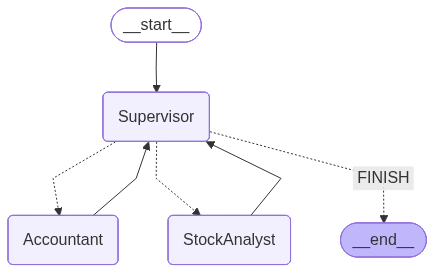

In [39]:
display(Image(app.get_graph().draw_mermaid_png()))

In [86]:
# --- TEST IT ---
if __name__ == "__main__":
    print("--- Testing Stock Analyst ---")
    #testing only get_stock_fundamentals
    # inputs = {"messages": [HumanMessage(content="Help me do the fundamental analysis for NVDA stock and another 4 of its competitors in the AI computing field")]} 

    #testing only get_stock_news
    # inputs = {"messages": [HumanMessage(content="How is the market sentiment for SuperMicro Computers lately?")]} 
    
    #testing only get_technical_indicators
    inputs = {"messages": [HumanMessage(content="How is NVDA's RSI and MACD performing lately?")]}

    #testing get_stock_fundamentals, get_stock_news, get_technical_indicators together
    # inputs = {"messages": [HumanMessage(content="How is Intel doing lately?")]}
    # inputs = {"messages": [HumanMessage(content="Lets analyze Symbotic")]} 
    
    for output in app.stream(inputs):
        for key, value in output.items():
            print(f"Node '{key}':")
            print(value)
    print("--- Done ---")

--- Testing Stock Analyst ---
Node 'Supervisor':
{'next_step': 'StockAnalyst'}
Node 'StockAnalyst':
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_technical_indicators', 'arguments': '{"ticker": "NVDA"}'}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019b1c37-c29a-7692-9bf5-41da45d9295a-0', tool_calls=[{'name': 'get_technical_indicators', 'args': {'ticker': 'NVDA'}, 'id': '1db151c8-ffeb-4398-9fe7-0b5365e528df', 'type': 'tool_call'}], usage_metadata={'input_tokens': 680, 'output_tokens': 8, 'total_tokens': 688, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='{"current_price": "$175.02", "sma_50": "$186.84", "trend_50_day": "Downtrend", "rsi_14": "45.0", "rsi_status": "Neutral", "macd_line": "-1.94", "macd_signal": "-1.78", "macd_interpretation": "Bearish"}', name='get_technical_indicators', id='9316a122-2615-4b86-a819-c6c35f050474